In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numba

In [3]:
from ePModel import ePModel

In [4]:
%matplotlib inline

In [5]:
isNEURONInstalled = True  # set True only if a working installation of NEURON and its python binding (pyneuron) is available

# Simulation parameters

In [6]:
C_dend      = 1.0e-2    # Dendritic tree membrane capacitance (F / m2 )
rhom_dend   = 28.0e-1   # Dendritic tree membrane resistivity (Ohm m2)
rha_dend    = 1.5       # Dendritic tree membrane internal resistivity (Ohm m)
d_dend      = 1.2e-6    # Dendritic tree diameter (m)
L_dend      = 700.0e-6  # Dendritic tree length (m)

# Soma (here we take the same values for the soma and dendritic tree as was done in Rattay 1999)
C_soma      = 1.0e-2    # Soma membrane capacitance (F / m2)
rhom_soma   = 28.0e-1   # Soma membrane resistivity (Ohm m2)
d_soma      = 10e-6     # Soma diameter ( m )
E_freq      = 10.        # Field frequency ( in Hz )
E_amp       = 1.         # Field amplitude ( V/m )
E_n         = 20        # Number of cycle the field is applied
E_onset     = 0         # Field onset time (ms)

In [7]:
V0      = 0.     # Base membrane potential in this absence of input (mV)
VT      = 10.    # Spike threshold (mV)
T_ref   = 1.5    # Refractory time after each spike (ms)  

In [8]:
duration= 3000.     # Simulation duration (ms)

In [9]:
OUNoise_soma_mean   = 0.003
OUNoise_soma_std    = 0.01
OUNoise_dend_mean   = 0.003
OUNoise_dend_std    = 0.01

# Extended point neuron model (eP)

## Init the eP model

In [10]:
eP = ePModel()

## Run the eP model alone

In this section the extended point (eP) neuron model is run alone, i.e. without the Ball & Stick (BS) neuron model. This section can be run without install NEURON.

In [11]:
@numba.njit
def generateOUNoise(t_s,Tau_OU_s, stdOU):
    '''
    This function generate an Ornstein-Uhlenbeck noise realization

    Parameters:
        :param t_s:         Time samples for the OU noise
        :param Tau_OU_s:    OU process time constant
        :param stdOU:       OU process standard deviation
    
    :returns OUNoise:       OU noise realization.
    '''
    OUNoise = np.zeros_like(t_s)

    if Tau_OU_s == 0.:
        for i in xrange(len(OUNoise)):
            OUNoise[i] = stdOU * np.random.randn()
        return OUNoise

    OUNoise = np.zeros_like(t_s)
    dt  = t_s[1] - t_s[0]
    D   = 2 * stdOU * stdOU / Tau_OU_s
    mu  = np.exp(-dt/Tau_OU_s)
    amp = stdOU * np.sqrt( (1-np.exp(-2*dt/Tau_OU_s)) )

    for i in xrange(len(t_s) - 1):
        OUNoise[i+1]= mu * OUNoise[i] + amp * np.random.randn()

    return OUNoise

In [12]:
dt = 0.1 # Integration time in ms

In [13]:
t = np.arange(0,duration,dt)

In [14]:
OUNoise_soma = generateOUNoise(t*1e-3,0.5e-3,OUNoise_soma_std) + OUNoise_soma_mean
OUNoise_dend = generateOUNoise(t*1e-3,0.5e-3,OUNoise_dend_std) + OUNoise_dend_mean

In [15]:
# Compute the eP input currents
I_soma_eP = eP.computeEquivalentInputCurrentFromBSInput(t*1e-3,OUNoise_soma*1e-9,0)
I_dend_eP = eP.computeEquivalentInputCurrentFromBSInput_dend(t*1e-3,OUNoise_dend*1e-9,0)
I_ext_eP = I_soma_eP + I_dend_eP

I_ext_ep = I_soma_eP

# Run the eP model
t_eP, V_eP, E_eP = eP.runSim(dt=dt*1e-3,duration=duration*1e-3,E_onset=E_onset,E_amp=E_amp,E_freq=E_freq,
                             E_n=E_n,V0=0,I_ext=I_ext_eP)

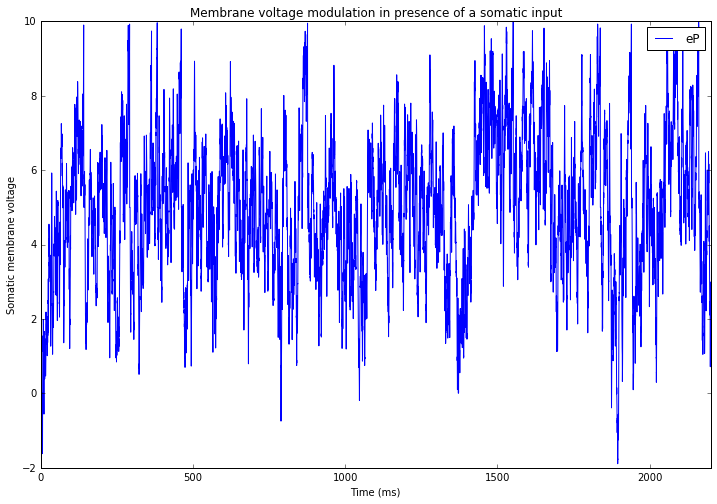

In [16]:
plt.figure(figsize=(12.,8.))
plt.plot(t_eP*1e3,V_eP*1e3,label='eP')
plt.legend()
plt.ylabel('Somatic membrane voltage')
plt.xlabel('Time (ms)')
plt.xlim([0,2200])
plt.title('Membrane voltage modulation in presence of a somatic input')

# BS neuron model

In the following section a working installation of NEURON and its python binding (pyneuron) is needed in order to run the BS model.

In [17]:
if isNEURONInstalled:
    import sys
    sys.path.append("/usr/local/nrn/lib/python/") # Add pyneuron path
    import neuron

## Create and BS model in Neuron

In [18]:
if isNEURONInstalled:
    h = neuron.h

    # Load BS structure
    h('load_file("BS_morphology.hoc")')

    # Add vector to record diverse variables
    h('objref tVec')
    h('tVec = new Vector()')
    h.tVec.record(h._ref_t)

    # Somatic membrane voltage
    h('objref v0Vec')
    h('v0Vec = new Vector()')
    h.v0Vec.record(h.dend(0)._ref_v)

    # Field
    h('objref fsinVec')
    h('fsinVec = new Vector()')
    h.fsinVec.record(h.fsin._ref_x)

    t   = h.tVec
    v0  = h.v0Vec

    # Input noise
    # OU noise = background noise

    h("access soma")
    h("objref spkout")
    h("spkout = new SpikeOut(0.5)")


    # Add OU Noise input at the soma
    h("access soma")
    h("objref OUNoiseStim")
    h("OUNoiseStim = new IClampOU(0.5)")
    h('objref OUNoiseVec')
    h('OUNoiseVec = new Vector()')
    h.OUNoiseVec.record(h.OUNoiseStim._ref_i)


    # Add OU Noise input at the dendritic end
    h("access dend")
    h("objref OUNoiseStim_dend")
    h("OUNoiseStim_dend = new IClampOU(1)")
    h('objref OUNoiseVec_dend')
    h('OUNoiseVec_dend = new Vector()')
    h.OUNoiseVec_dend.record(h.OUNoiseStim_dend._ref_i)


    h.OUNoiseStim.mean        = OUNoise_soma_mean
    h.OUNoiseStim.std         = OUNoise_soma_std

    h.OUNoiseStim_dend.mean   = OUNoise_dend_mean
    h.OUNoiseStim_dend.std    = OUNoise_dend_std

    h.OUNoiseStim.tau         = 0.5
    h.OUNoiseStim_dend.tau    = 0.5


    # Set the BS model parameters
    ## Soma
    h.soma.diam = d_soma * 1e6    # um
    h.soma.L    = d_soma * 1e6    # um
    h.soma.Ra   = rha_dend * 1e2  # Ohm cm

    for seg in h.soma:
        seg.cm      = C_soma * 1e2    # uF / cm2
        seg.pas.g   = 1.0/(rhom_soma * 1e4)   # S/cm2

    ## Dendrite
    h.dend.diam = d_dend * 1e6    # um
    h.dend.L    = L_dend * 1e6    # um
    h.dend.Ra   = rha_dend * 1e2  # Ohm cm

    for seg in h.dend:
        seg.cm      = C_dend * 1e2    # uF/cm2
        seg.pas.g   = 1.0/(rhom_dend * 1e4)   # S/cm2
        # Update the external potential amplitude
        seg.xtra.rx = - seg.x * h.dend.L * 1e-3 * 1e-6


    # Set the "base" membrane potential for the soma and dendrite to V0
    h.finitialize(V0)
    h.fcurrent()
    for s in h.allsec():
        for seg in s:
            currents = 0
            seg.pas.e = seg.v / seg.pas.g 

    h.spkout.vrefrac = V0
    h.spkout.refrac = T_ref
    h.spkout.thresh = VT


    h.fsin.delay = E_onset

AttributeError: 'hoc.HocObject' object has no attribute 'fsin'

In [19]:
def runBSModel(duration=duration,
               OUNoise_soma_mean=OUNoise_soma_mean, OUNoise_soma_std=OUNoise_soma_std,
               OUNoise_dend_mean=OUNoise_dend_mean, OUNoise_dend_std=OUNoise_dend_std,
              E_freq = E_freq, E_amp = E_amp, E_n= E_n):
    '''
    Run the BS model for a given parameters and returns the voltage traces as well as the input currents
    
    Parameters:
        :param duration:            Simulation duration (ms)
        :param OUNoise_soma_mean:   Mean input at the soma (nA)
        :param OUNoise_soma_std:    Standard deviation of the OU input at the soma (nA)
        :param OUNoise_dend_mean:   Mean input at the dendritic end (nA)
        :param OUNoise_dend_std:    Standard deviation of the OU input at the dendritic end (nA)
        :param E_freq:              Applied extracellular field frequency (Hz)
        :param E_amp:               Applied extracellular amplitude ( V/m )
        :param E_n:                 Number of cycles the extracellular field is applied
    
    :returns:           t,V_BS, OUNoise_soma, OUNoise_dend
        t               Time samples (ms)
        V_BS            Somatic membrane potential of the BS neuron (mV)
        OUNoise_soma    Somatic input current (nA)
        OUNoise_dend    Dendritic end input current (nA)
    '''
    # Init the input current
    h.OUNoiseStim.mean        = OUNoise_soma_mean
    h.OUNoiseStim.std         = OUNoise_soma_std

    h.OUNoiseStim_dend.mean   = OUNoise_dend_mean
    h.OUNoiseStim_dend.std    = OUNoise_dend_std
    
    
    # Init the extracellular field
    h.fsin.f    = E_freq
    h.fsin.amp  = E_amp
    #h.fsin.del  = 200.
    h.fsin.n    = E_n

    
    # Reinit the voltage potential to the resting value
    for sec in h.allsec():
        for seg in sec.allseg():
            seg.v = V0

    neuron.init()
    
    # Run the simulation
    neuron.run(duration)
    

    # Read the variable time traces
    t               = h.tVec.as_numpy().copy()
    V_BS            = h.v0Vec.as_numpy().copy()
    OUNoise_soma    = h.OUNoiseVec.as_numpy().copy()
    OUNoise_dend    = h.OUNoiseVec_dend.as_numpy().copy()
    
    return t, V_BS, OUNoise_soma, OUNoise_dend

# Simulations 

## Effect of the extracellular field

In [20]:
if isNEURONInstalled:
    _ = runBSModel(OUNoise_dend_std=0, OUNoise_soma_std=0, OUNoise_dend_mean=0, OUNoise_soma_mean=0)
    t, V_BS, OUNoise_soma, OUNoise_dend = _

AttributeError: 'hoc.HocObject' object has no attribute 'OUNoiseStim'

In [21]:
# Compute the eP input currents
I_soma_eP = eP.computeEquivalentInputCurrentFromBSInput(t*1e-3,OUNoise_soma*1e-9,0)
I_dend_eP = eP.computeEquivalentInputCurrentFromBSInput_dend(t*1e-3,OUNoise_dend*1e-9,0)
I_ext_eP = I_soma_eP + I_dend_eP

# Run the eP model
t_eP, V_eP, E_eP = eP.runSim(dt=t[1]*1e-3,duration=duration*1e-3,E_onset=E_onset,E_amp=E_amp,E_freq=E_freq,
                             E_n=E_n,V0=0,I_ext=I_ext_eP)

NameError: name 'V_BS' is not defined

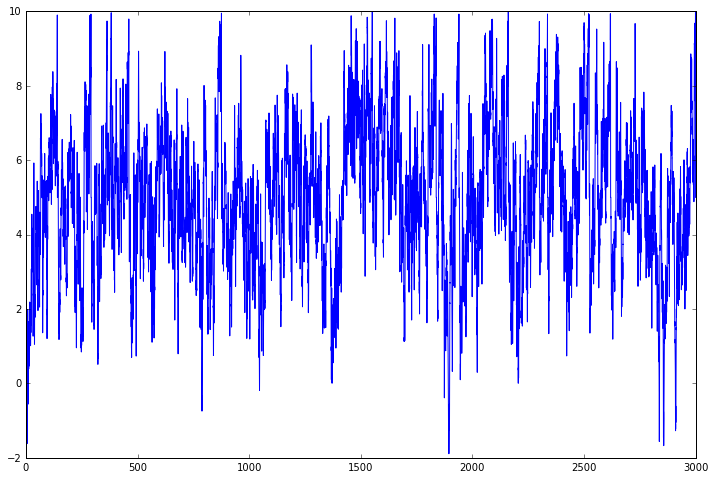

In [22]:
plt.figure(figsize=(12.,8.))
plt.plot(t_eP*1e3,V_eP*1e3,label='eP')
if isNEURONInstalled:
    plt.plot(t,V_BS,label='BS')
    plt.legend()
plt.ylabel('Somatic membrane voltage')
plt.xlabel('Time (ms)')
plt.xlim([0,2200])
plt.title('Membrane voltage modulation in presence of an extracellular field')

## Somatic input

In [23]:
if isNEURONInstalled:
    _ = runBSModel(OUNoise_dend_std=0, OUNoise_dend_mean=0 , E_amp=0)
    t, V_BS, OUNoise_soma, OUNoise_dend = _

AttributeError: 'hoc.HocObject' object has no attribute 'OUNoiseStim'

In [24]:
# Compute the eP input currents
I_soma_eP = eP.computeEquivalentInputCurrentFromBSInput(t*1e-3,OUNoise_soma*1e-9,0)
I_dend_eP = eP.computeEquivalentInputCurrentFromBSInput_dend(t*1e-3,OUNoise_dend*1e-9,0)
I_ext_eP = I_soma_eP + I_dend_eP

# Run the eP model
t_eP, V_eP, E_eP = eP.runSim(dt=t[1]*1e-3,duration=duration*1e-3,E_onset=E_onset,E_amp=0,E_freq=E_freq,
                             E_n=E_n,V0=0,I_ext=I_ext_eP)

NameError: name 'V_BS' is not defined

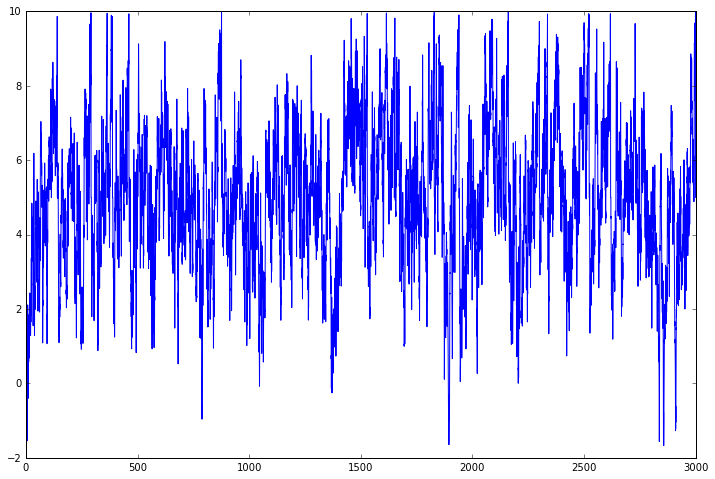

In [25]:
plt.figure(figsize=(12.,8.))
plt.plot(t_eP*1e3,V_eP*1e3,label='eP')
if isNEURONInstalled:
    plt.plot(t,V_BS,label='BS')
    plt.legend()
plt.ylabel('Somatic membrane voltage')
plt.xlabel('Time (ms)')
plt.xlim([0,2200])
plt.title('Membrane voltage modulation in presence of a somatic input')

## Dendritic input

In [26]:
if isNEURONInstalled:
    _ = runBSModel(OUNoise_soma_std=0, OUNoise_soma_mean= 0, E_amp=0)
    t, V_BS, OUNoise_soma, OUNoise_dend = _

AttributeError: 'hoc.HocObject' object has no attribute 'OUNoiseStim'

In [27]:
# Compute the eP input currents
I_soma_eP = eP.computeEquivalentInputCurrentFromBSInput(t*1e-3,OUNoise_soma*1e-9,0)
I_dend_eP = eP.computeEquivalentInputCurrentFromBSInput_dend(t*1e-3,OUNoise_dend*1e-9,0)
I_ext_eP = I_soma_eP + I_dend_eP

# Run the eP model
t_eP, V_eP, E_eP = eP.runSim(dt=t[1]*1e-3,duration=duration*1e-3,E_onset=E_onset,E_amp=0,E_freq=E_freq,
                             E_n=E_n,V0=0,I_ext=I_ext_eP)

NameError: name 'V_BS' is not defined

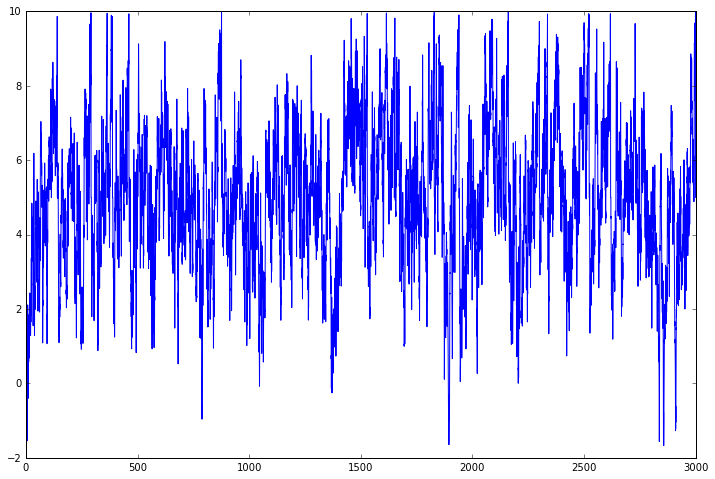

In [28]:
plt.figure(figsize=(12.,8.))
plt.plot(t_eP*1e3,V_eP*1e3,label='eP')
if isNEURONInstalled:
    plt.plot(t,V_BS,label='BS')
    plt.legend()
plt.ylabel('Somatic membrane voltage')
plt.xlabel('Time (ms)')
plt.xlim([0,2200])
plt.title('Membrane voltage modulation in presence of a dendritic input')

## Field + somatic and dendritic inputs

In [29]:
if isNEURONInstalled:
    _ = runBSModel()
    t, V_BS, OUNoise_soma, OUNoise_dend = _

AttributeError: 'hoc.HocObject' object has no attribute 'OUNoiseStim'

In [30]:
# Compute the eP input currents
I_soma_eP = eP.computeEquivalentInputCurrentFromBSInput(t*1e-3,OUNoise_soma*1e-9,0)
I_dend_eP = eP.computeEquivalentInputCurrentFromBSInput_dend(t*1e-3,OUNoise_dend*1e-9,0)
I_ext_eP = I_soma_eP + I_dend_eP

# Run the eP model
t_eP, V_eP, E_eP = eP.runSim(dt=t[1]*1e-3,duration=duration*1e-3,E_onset=E_onset,E_amp=E_amp,E_freq=E_freq,
                             E_n=E_n,V0=0,I_ext=I_ext_eP)

NameError: name 'V_BS' is not defined

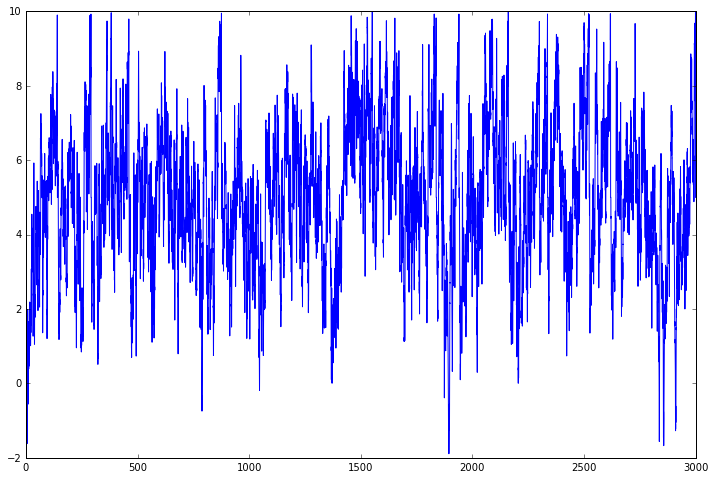

In [31]:
plt.figure(figsize=(12.,8.))
plt.plot(t_eP*1e3,V_eP*1e3,label='eP')
if isNEURONInstalled:
    plt.plot(t,V_BS,label='BS')
    plt.legend()
plt.ylabel('Somatic membrane voltage')
plt.xlabel('Time (ms)')
plt.xlim([0,2200])
plt.title('Membrane voltage modulation in presence of a somatic and dendritic input')